In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.tree import DecisionTreeClassifier
from gefs.sklearn_utils import tree2pc

from gefs.adversarial import pgd_linf,epoch_adversarial_training
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap

def plot_decision_region(X,y,classifier,resolution=0.02):
    markers = ('s','x','o','^','v')
    colors = ('red','blue','lightgreen','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min,x1_max = X[:,0].min()-1,X[:,0].max()+1

    x2_min,x2_max = X[:,1].min()-1,X[:,1].max()+1

    xx1,xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution),
                         np.arange(x2_min,x2_max,resolution))

    if hasattr(classifier,'classify'):
        Z = classifier.classify(torch.tensor(np.array([xx1.ravel(),xx2.ravel()]).T))
    else:
        Z = classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)

    Z = Z.reshape(xx1.shape)

    plt.contourf(xx1,xx2,Z,alpha=0.3,cmap=cmap)
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())

    # plot class samples
    for idx,cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl,0],
                   y = X[y==cl,1],
                   alpha=0.8,
                   c=colors[idx],
                   marker = markers[idx],
                   label=cl,
                   edgecolors='black')

In [3]:
# Define a synthetic dataset
n_samples = 200
n_features = 2
n_classes = 4

X, y = make_classification(n_samples=n_samples, n_features=n_features, n_informative=2, n_redundant=0, n_repeated=0,
                           n_classes=n_classes, n_clusters_per_class=1, weights=None, flip_y=0.01, class_sep=0.7,
                           hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)

# We need to specify the number of categories of each feature (with 1 for continuous features).
ncat = np.ones(n_features+1)  # Here all features are continuous
ncat[-1] = n_classes  # The class variable is naturally categorical

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# create editability vector
filename = 'Synthetic'

# Before Adversarial Training

## original decision tree and original soft GeDT

Original Decision Tree
Decision Tree accuracy: 0.6


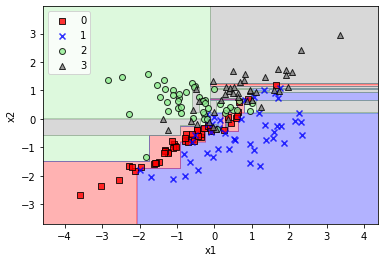

SoftGeDT(initial)
SoftGeDT(initial) accuracy: tensor(0.7000)


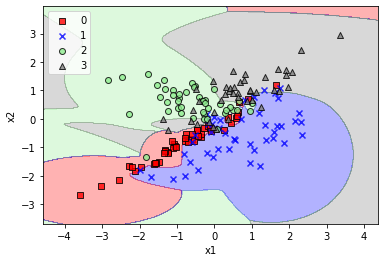

In [4]:
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)
pred = tree.predict(X_test)
print("Original Decision Tree")
print("Decision Tree accuracy:",np.sum(pred==y_test)/y_test.shape[0])
plot_decision_region(X_train,y_train,classifier=tree,resolution=0.01)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc='upper left')
plt.show()

X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

synthetic_train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
BATCH_SIZE = 32
synthetic_train_loader = torch.utils.data.DataLoader(synthetic_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

synthetic_test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
BATCH_SIZE = 32
synthetic_test_loader = torch.utils.data.DataLoader(synthetic_test_dataset, batch_size=BATCH_SIZE, shuffle=True)

SoftGeDT = tree2pc(tree, X_train, y_train, ncat, learnspn=30, minstd=.1, smoothing=0.1)
pred = SoftGeDT.classify(X_test)
print("SoftGeDT(initial)")
print("SoftGeDT(initial) accuracy:",torch.sum(pred==y_test)/y_test.shape[0])
plot_decision_region(X_train,y_train,classifier=SoftGeDT,resolution=0.01)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc='upper left')
plt.show()

## soft GeDT with normal training

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
SoftGeDT after training
SoftGeDT accuracy: tensor(0.6500)
SoftGeDT adversarial error: 0.4


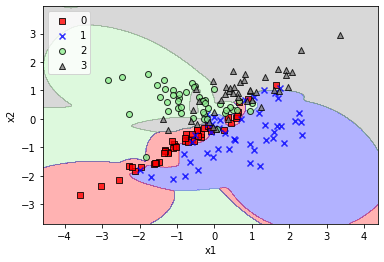

In [5]:
opt = torch.optim.Adam(SoftGeDT.gate_weights+SoftGeDT.gate_split_values+SoftGeDT.sum_weights, lr=0.1)
EPOCHS =10

training_epoch_num_correct = [0 for i in range(EPOCHS)]
training_epoch_num_total = [0 for i in range(EPOCHS)]
acc_epoch_train =  [0 for i in range(EPOCHS)]

for i in range(EPOCHS):
    print("epoch:",i)
    for X,y in synthetic_train_loader:
        opt.zero_grad()
        pred, prob = SoftGeDT.classify(X,return_prob=True)
        loss =F.nll_loss(torch.log(prob),y.type(torch.int64),reduction='sum')
        loss.backward()
        opt.step()

        training_epoch_num_correct[i] += torch.sum(pred==y)
        training_epoch_num_total[i] += y.shape[0]

acc_epoch_train[i] = training_epoch_num_correct[i]/training_epoch_num_total[i]

err_test, test_total_loss, X_advs,y_advs = epoch_adversarial_training(synthetic_test_loader,SoftGeDT,pgd_linf,return_adv=True,non_editable_vector=None,clipping_max=None,clipping_min=None,datatypes=None,num_iter=10,epsilon=0.1,L1_REG=None,omega=None)
X_adv=X_advs[0]
y_adv = y_advs[0]
for i in range(1,len(X_advs)):
    X_adv=torch.cat((X_adv,X_advs[i]),dim=0)
    y_adv = torch.cat((y_adv,y_advs[i]),dim=0)

pred = SoftGeDT.classify(X_test)
print("SoftGeDT after training")
print("SoftGeDT accuracy:",torch.sum(pred==y_test)/y_test.shape[0])
print("SoftGeDT adversarial error:", err_test)
plot_decision_region(X_train,y_train,classifier=SoftGeDT,resolution=0.01)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc='upper left')
plt.show()

## Hard GeDT

HardGeDT
HardGeDT accuracy: tensor(0.6000)
HardGeDT adversarial error: tensor(0.5000)


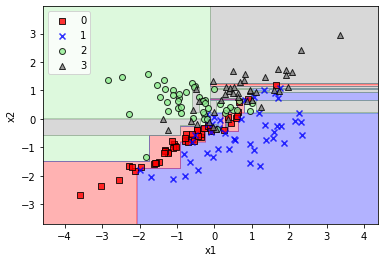

In [6]:
HardGeDT = tree2pc(tree, X_train, y_train, ncat, learnspn=30, minstd=.1, smoothing=0.1)
for k in range(len(HardGeDT.gate_weights)):
    HardGeDT.gate_weights[k].data = torch.tensor([-np.inf])

pred = HardGeDT.classify(X_test)
plot_decision_region(X_train,y_train  ,classifier=HardGeDT,resolution=0.01)
pred_adv = HardGeDT.classify(X_adv)
err_test = torch.sum(pred_adv!=y_adv)/y_adv.shape[0]

print("HardGeDT")
print("HardGeDT accuracy:",torch.sum(pred==y_test)/y_test.shape[0])
print("HardGeDT adversarial error:",err_test)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc='upper left')
plt.show()

# After Adversarial Training

## Soft GeDT with adversarial training

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
SoftGeDTAdv after training
SoftGeDTAdv accuracy: tensor(0.7500)
SoftGeDTAdv adversarial error: 0.3


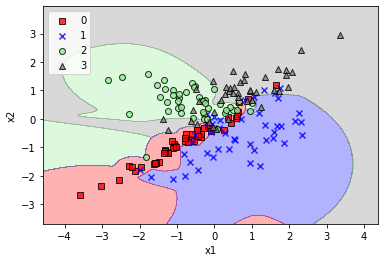

In [7]:
SoftGeDTAdv = tree2pc(tree, X_train, y_train, ncat, learnspn=30, minstd=.1, smoothing=0.1)
opt= torch.optim.Adam(SoftGeDTAdv.gate_weights+SoftGeDTAdv.gate_split_values+SoftGeDTAdv.sum_weights, lr=0.01)
EPOCHS =10
err_epoch_train =  [0 for i in range(EPOCHS)]

for i in range(EPOCHS):
    print("epoch:",i)
    for X,y in synthetic_train_loader:
        err_epoch_train[i], train_total_loss = epoch_adversarial_training(synthetic_train_loader,SoftGeDTAdv,pgd_linf,opt=opt,non_editable_vector=None,clipping_max=None,clipping_min=None,datatypes=None,num_iter=10,epsilon=0.1,L1_REG=None,omega=None)

err_test, test_total_loss = epoch_adversarial_training(synthetic_test_loader,SoftGeDTAdv,pgd_linf,non_editable_vector=None,clipping_max=None,clipping_min=None,datatypes=None,num_iter=10,epsilon=0.1,L1_REG=None,omega=None)

pred = SoftGeDTAdv.classify(X_test)
print("SoftGeDTAdv after training")
print("SoftGeDTAdv accuracy:",torch.sum(pred==y_test)/y_test.shape[0])
print("SoftGeDTAdv adversarial error:", err_test)
plot_decision_region(X_train,y_train,classifier=SoftGeDTAdv,resolution=0.01)
plt.xlabel('x1')

plt.ylabel('x2')
plt.legend(loc='upper left')
plt.show()